In [1]:
import cvxpy as cp
import numpy as np
import pandas as pd
import seaborn as sns
import viz

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from os import path
from linear_opt.lin_metabolism import MW_C_ATOM
from linear_opt.lin_metabolism import LinearMetabolicModel
from linear_opt.lin_metabolism import GrowthRateOptParams
from linear_opt.lin_metabolism import SingleSubstrateMMRateLaw
from linear_opt.lin_metabolism import MultiSubstrateMMRateLaw
from matplotlib.ticker import LogFormatter 

colors = viz.plotting_style()
color_order = ['green', 'blue', 'red', 'purple', 'yellow', 'dark_green', 'dark_blue', 'dark_brown']
lin_colors = [colors[c] for c in color_order]
plt.style.use('style.mpl')

# Approximate concentrations and ratios for plotting
# Based on Bennett et al. 2009 measurements in E. coli
DEFAULT_ATP = 1.4e-6
DEFAULT_NADH = 1.2e-7
DEFAULT_RE = 10
DEFAULT_RA = 0.3
DEFAULT_NAD = DEFAULT_NADH * DEFAULT_RE
DEFAULT_ADP = DEFAULT_ATP * DEFAULT_RA

In [2]:
model_dir = '../models/linear/respiration/'
m_fname = path.join(model_dir, 'glucose_resp_molecular_props.csv')
S_fname = path.join(model_dir, 'glucose_resp_stoich_matrix.csv')
lam = LinearMetabolicModel.FromFiles(m_fname, S_fname)
#lam.print_model()

In [3]:
g_ana = (lam.kcat_s/lam.m_Da)[2]
print("{0:.1g}".format(g_ana))

# estimate of growth rate assuming phi_ana = (1-min_phi_0) = 0.6
min_phi_0 = 0.4
print((1-min_phi_0)*g_ana*12*3600)

5e-05
1.296


In [4]:
# Calculate the growth rate for a zero order model. 
params = GrowthRateOptParams(min_phi_O=0.4, max_phi_H=0)
max_lam, opt_p = lam.maximize_growth_rate(params)
# Get the results as a dictionary
res_dict = lam.results_as_dict(opt_p, params)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-03


In [5]:
# sanity check the value of gamma for anabolism
anabolism_gamma = res_dict['anabolism_gamma']
ana_kcat_s = res_dict['anabolism_kcat_s']
ana_m_kDa = res_dict['anabolism_m_kDa']
# factor of 1000 converts from kDa to Da
# factor 2 accounts for ≈50% of mass being carbon
expected_gamma = ana_kcat_s/(ana_m_kDa*1000/2)
print('g_ana', anabolism_gamma)
print('expected g_ana', expected_gamma)

# Do we get a reasonable maximum growth rate?
analytic_gamma_ub = anabolism_gamma*12*3600*(1-res_dict['min_phi_0'])
print('analytic gamma ub', analytic_gamma_ub, '/hr')


g_ana 0.0001
expected g_ana 0.0001
analytic gamma ub 4.32 /hr


In [6]:
# Concentrations are typically ~1 mM, converting to mol/gCDW
# If the density rho ≈ 1000 g/L, 1/rho ≈ 1e-3 L/g = 1 mL/g so... 
# 1e-3 mol/L x 1e-3 L/g x 0.3 gDW/g x 2 gDW/gCDW = 1.5e-7 mol/gCDW
params = GrowthRateOptParams(min_phi_O=0.4, 
                             do_dilution=True,
                             rate_law=SingleSubstrateMMRateLaw(),
                             fixed_ATP=DEFAULT_ATP, fixed_NADH=DEFAULT_NADH,
                             fixed_re=DEFAULT_RE, fixed_ra=DEFAULT_RE)
max_lam, opt_p = lam.maximize_growth_rate(params)
print('max growth rate', max_lam)



max growth rate 1.3439801528975348


/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


In [7]:
concs = np.logspace(-7, -1, 50)
ATPgrid, NADHgrid = np.meshgrid(concs, concs)
lambda_grid = np.zeros_like(ATPgrid)

for i, ATP in enumerate(concs):
    for j, NADH in enumerate(concs):
        params = GrowthRateOptParams(min_phi_O=0.4, do_dilution=True,
                                     fixed_ATP=ATP, fixed_NADH=NADH,
                                     fixed_re=DEFAULT_RE, fixed_ra=DEFAULT_RA)
        opt, _ = lam.maximize_growth_rate(params)
        lambda_grid[i, j] = opt

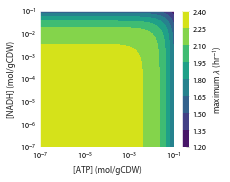

In [8]:
plt.figure(figsize=(3, 2.5))
plt.xscale('log')
plt.yscale('log')
plt.contourf(ATPgrid, NADHgrid, lambda_grid, cmap='viridis')
plt.xlabel('[ATP] (mol/gCDW)')
plt.ylabel('[NADH] (mol/gCDW)')
cb = plt.colorbar(label=r'maximum $\lambda$ (hr$^{-1}$)')
plt.show()

In [9]:
# Same as above, multi-substrate michaelis menten rate law
concs = np.logspace(-8, -1, 50)
ATPgrid, NADHgrid = np.meshgrid(concs, concs)
lambda_grid = np.zeros_like(ATPgrid)

for i, ATP in enumerate(concs):
    for j, NADH in enumerate(concs):
        rl = MultiSubstrateMMRateLaw()
        params = GrowthRateOptParams(min_phi_O=0.4, do_dilution=True,
                                     fixed_ATP=ATP, fixed_NADH=NADH,
                                     fixed_re=10, fixed_ra=0.3,
                                     rate_law=rl)
        opt = np.NaN
        try:
            opt, _ = lam.maximize_growth_rate(params)
        except:
            # Optimal solution not found
            pass
        
        lambda_grid[i, j] = opt

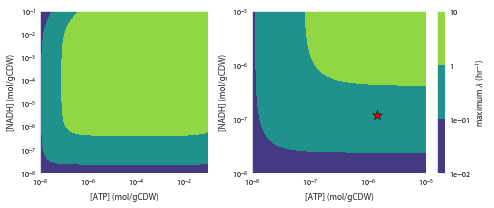

In [10]:
fig, axs = plt.subplots(figsize=(7, 3), ncols=2, width_ratios=[1, 1.3])

plt.sca(axs[0])
plt.xscale('log')
plt.yscale('log')
plt.contourf(ATPgrid, NADHgrid, lambda_grid, cmap='viridis', norm=LogNorm())
plt.xlabel('[ATP] (mol/gCDW)')
plt.ylabel('[NADH] (mol/gCDW)')

plt.sca(axs[1])
# plot zoomed in on the range of ATP and NADH concentrations we care about
# which are 1e-8 to 1e-5 for both 
plt.xscale('log')
plt.yscale('log')
plt.contourf(ATPgrid, NADHgrid, lambda_grid, cmap='viridis', norm=LogNorm())
plt.xlabel('[ATP] (mol/gCDW)')
plt.ylabel('[NADH] (mol/gCDW)')
plt.xlim(1e-8, 1e-5)
plt.ylim(1e-8, 1e-5)
formatter = LogFormatter(10, labelOnlyBase=False)
cb = plt.colorbar(label=r'maximum $\lambda$ (hr$^{-1}$)', format=formatter)

# put a * at the Bennet concentrations of ATP ≈ 1.4e-6 (9.6 mM) and NADH ≈ 1.2e-7 (83 uM)
A = DEFAULT_ATP
N = DEFAULT_NADH
plt.scatter(A, N, marker='*', color='red', edgecolor='k', lw=0.5, s=100)

plt.tight_layout()
plt.show()

In [11]:
# Here is a model that has no homeostasis (phi_H <= 0),
# no maintenance (ATP_maint = 0), but can alter biomass
# composition through phi_O. We set a maximum lambda
# so that we can run the model over a range of lambda values.
params = GrowthRateOptParams(min_phi_O=0.4, do_dilution=True, 
                             max_lambda_hr=0.1, max_phi_H=0,
                             fixed_ATP=DEFAULT_ATP, fixed_NADH=DEFAULT_NADH,
                             fixed_re=DEFAULT_RE, fixed_ra=DEFAULT_RA)
                             
lam = LinearMetabolicModel.FromFiles(m_fname, S_fname)
p = lam.max_growth_rate_problem(params)
lambdas = np.arange(0.1, 4, 0.01)
results = []

for lam_val in lambdas:
    p.param_dict['max_lambda_hr'].value = lam_val
    res = p.solve()
    d = lam.results_as_dict(p, params)
    results.append(d)

phi_df = pd.DataFrame(results)
phi_df.head()

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


,oxidation_kcat_s,oxidation_m_kDa,reduction_kcat_s,reduction_m_kDa,anabolism_kcat_s,anabolism_m_kDa,ATP_homeostasis_kcat_s,ATP_homeostasis_m_kDa,ZCB,ZCorg,...,opt.fixed_ra,opt.fixed_re,opt.rate_law_name,opt.rate_law_order,analytic_lambda_zo,analytic_lambda_max_zo,S6_lb_zo,S6_ub_zo,ZCorg_lb_zo,ZCorg_ub_zo
0,50.0,1000.0,200.0,1000.0,50.0,1000.0,50.0,1000.0,0.0,0.0,...,0.3,10,ZeroOrder,0,0.10,0.10,0.15001,-1.200263,-0.30002,1.499883
1,50.0,1000.0,200.0,1000.0,50.0,1000.0,50.0,1000.0,0.0,0.0,...,0.3,10,ZeroOrder,0,0.11,0.11,0.15001,-1.200263,-0.30002,1.499883
2,50.0,1000.0,200.0,1000.0,50.0,1000.0,50.0,1000.0,0.0,0.0,...,0.3,10,ZeroOrder,0,0.12,0.12,0.15001,-1.200263,-0.30002,1.499883
3,50.0,1000.0,200.0,1000.0,50.0,1000.0,50.0,1000.0,0.0,0.0,...,0.3,10,ZeroOrder,0,0.13,0.13,0.15001,-1.200263,-0.30002,1.499883
4,50.0,1000.0,200.0,1000.0,50.0,1000.0,50.0,1000.0,0.0,0.0,...,0.3,10,ZeroOrder,0,0.14,0.14,0.15001,-1.200263,-0.30002,1.499883


2.592


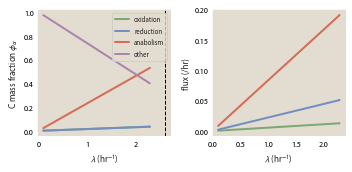

In [12]:
# Notice that phi_O increases as lambda decreases
fig, axs = plt.subplots(1, 2, figsize=(5, 2.5))

min_phi_O = 0.4
g_ana = phi_df.anabolism_gamma.values[0]
lambda_max = 12*3600*g_ana*(1-min_phi_O)
print(lambda_max)
plt.sca(axs[0])

x = phi_df['lambda_hr']
# Not plotting homeostasis because it was set to zero
processes = 'oxidation,reduction,anabolism'.split(',')
phi_cols = ['{}_phi'.format(p) for p in processes] + ['phi_O']
for i, col in enumerate(phi_cols):
    label = processes[i] if i < len(processes) else r'other'
    plt.plot(x, phi_df[col], label=label, color=lin_colors[i])

plt.axvline(lambda_max, color='k', ls='--', lw=1) 
plt.xlabel(r'$\lambda$ (hr$^{-1}$)')
plt.ylabel(r'C mass fraction $\phi_\alpha$')   
plt.legend(loc=1)

plt.sca(axs[1])
j_cols = ['{}_flux'.format(p) for p in processes]
for i, col in enumerate(j_cols):
    plt.plot(x, phi_df[col]*3600, label=processes[i], color=lin_colors[i])
plt.xlabel(r'$\lambda$ (hr$^{-1}$)')
plt.ylabel(r'flux (/hr)')
plt.legend(loc=1).set_visible(False)

plt.tight_layout()
plt.show()


In [13]:
# Sweep a range of biomass ZC values
ZCBs = np.arange(-3, 3.01, 0.05)

results = []
lmm = LinearMetabolicModel.FromFiles(m_fname, S_fname)

for z in ZCBs:
    # Test with and without ATP homeostasis -- first with
    ref_lam = lmm.copy()
    ref_lam.set_ZCB(z)

    # Note we are fixing phi_O here to highlight the contribution of phi_H
    params = GrowthRateOptParams(phi_O=0.4, do_dilution=True,
                                fixed_ATP=DEFAULT_ATP, fixed_NADH=DEFAULT_NADH,
                                fixed_re=DEFAULT_RE, fixed_ra=DEFAULT_RA)
    m, opt_p = ref_lam.maximize_growth_rate(params)
    d = ref_lam.model_as_dict()
    d.update(ref_lam.solution_as_dict(opt_p, params))
    d.update(params.as_dict())
    results.append(d)

    # Now without -- seting max_phi_H = 0
    params_nh = GrowthRateOptParams(phi_O=0.4, do_dilution=True, max_phi_H=0,
                                    fixed_ATP=DEFAULT_ATP, fixed_NADH=DEFAULT_NADH,
                                    fixed_re=DEFAULT_RE, fixed_ra=DEFAULT_RA)
    m, opt_p = ref_lam.maximize_growth_rate(params_nh)
    d = ref_lam.results_as_dict(opt_p, params_nh)
    results.append(d)

zcb_sensitivity_df = pd.DataFrame(results)

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)
/opt/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1343: UserWarning: 
    The problem is either infeasible or unbounded, but the solver
    cannot tell which. Disable any solver-specific presolve methods
    and re-solve to determine the precise problem status.

    For GUROBI and CPLEX you can automatically perform this re-solve
    with the keyword argument prob.solve(reoptimize=True, ...).
    
  warnings.warn(INF_OR_UNB_MESSAGE)


In [14]:
# Sweep a range of biomass ZC values
ZCorgs = np.arange(-3, 3.01, 0.05)

results = []
lmm = LinearMetabolicModel.FromFiles(m_fname, S_fname)

for z in ZCorgs:
    # Test with and without ATP homeostasis -- first with
    ref_lam = lmm.copy()
    ref_lam.set_ZCorg(z)
    # Note we are fixing phi_O here to highlight the contribution of phi_H
    params = GrowthRateOptParams(phi_O=0.4, do_dilution=True,
                                 fixed_ATP=DEFAULT_ATP, fixed_NADH=DEFAULT_NADH,
                                 fixed_re=DEFAULT_RE, fixed_ra=DEFAULT_RA)
    m, opt_p = ref_lam.maximize_growth_rate(params)
    d = ref_lam.results_as_dict(opt_p, params)
    results.append(d)

    # Now without -- seting max_phi_H = 0
    params_nh = GrowthRateOptParams(phi_O=0.4, do_dilution=True, max_phi_H=0,
                                    fixed_ATP=DEFAULT_ATP, fixed_NADH=DEFAULT_NADH,
                                    fixed_re=DEFAULT_RE, fixed_ra=DEFAULT_RA)
    m, opt_p = ref_lam.maximize_growth_rate(params_nh)
    d = ref_lam.results_as_dict(opt_p, params_nh)
    results.append(d)

zcorg_sensitivity_df = pd.DataFrame(results)

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)
/opt/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1343: UserWarning: 
    The problem is either infeasible or unbounded, but the solver
    cannot tell which. Disable any solver-specific presolve methods
    and re-solve to determine the precise problem status.

    For GUROBI and CPLEX you can automatically perform this re-solve
    with the keyword argument prob.solve(reoptimize=True, ...).
    
  warnings.warn(INF_OR_UNB_MESSAGE)


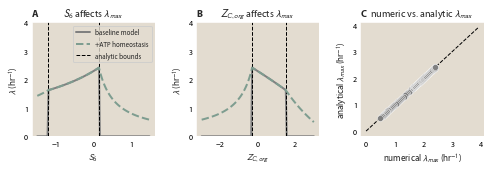

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(7, 2.5))


plt.sca(axs[0])
plt.title(r'$S_6$ affects $\lambda_{max}$')

zcbd = zcb_sensitivity_df
ZCB = zcbd.ZCB.values[0]
phi_H_included = zcbd[zcbd['opt.max_phi_H_set'] == False]
no_phi_H = zcbd[zcbd['opt.max_phi_H_set'] == True]

plt.plot(no_phi_H.S6, no_phi_H.lambda_hr, label=r'baseline model', color='grey')
plt.plot(phi_H_included.S6, phi_H_included.lambda_hr, label=r'+ATP homeostasis', 
         color=colors['dark_green'], ls='--', zorder=10)

plt.axvline(no_phi_H.S6_lb_zo.values[0], color='k', ls='--', lw=1, label='analytic bounds')
plt.axvline(no_phi_H.S6_ub_zo.values[0], color='k', ls='--', lw=1)
plt.ylim(0, 4)

plt.legend(loc=1)
plt.xlabel('$S_6$')
plt.ylabel(r'$\lambda$ (hr$^{-1}$)')

plt.sca(axs[1])
plt.title(r'$Z_{C,org}$ affects $\lambda_{max}$')

zcod = zcorg_sensitivity_df
phi_H_included = zcod[zcod['opt.max_phi_H_set'] == False]
no_phi_H = zcod[zcod['opt.max_phi_H_set'] == True]

plt.plot(no_phi_H.ZCorg, no_phi_H.lambda_hr, label=r'baseline model', color='grey')
plt.plot(phi_H_included.ZCorg, phi_H_included.lambda_hr, label=r'+ATP homeostasis', 
         color=colors['dark_green'], ls='--', zorder=10)

plt.axvline(no_phi_H.ZCorg_lb_zo.values[0], color='k', ls='--', lw=1, label='analytic bounds')
plt.axvline(no_phi_H.ZCorg_ub_zo.values[0], color='k', ls='--', lw=1)
plt.ylim(0, 4)

plt.legend(loc=1).set_visible(False)
plt.xlabel('$Z_{C,org}$')
plt.ylabel(r'$\lambda$ (hr$^{-1}$)')

plt.sca(axs[2])

xs = np.arange(0, 4, 0.1)
plt.plot(xs, xs, ls='--', color='k', lw=1, zorder=-10)

mask = zcorg_sensitivity_df['opt_status'] == 'optimal'
masked = zcorg_sensitivity_df[mask]
sns.scatterplot(data=masked, x='lambda_hr', y='analytic_lambda_max_zo', color='grey')

mask = zcb_sensitivity_df['opt_status'] == 'optimal'
masked = zcb_sensitivity_df[mask]
sns.scatterplot(data=masked, x='lambda_hr', y='analytic_lambda_max_zo', color='grey')

plt.ylabel(r'analytical $\lambda_{max}$ (hr$^{-1}$)')
plt.xlabel(r'numerical $\lambda_{max}$ (hr$^{-1}$)')
plt.title('numeric vs. analytic $\lambda_{max}$')

for i, label in enumerate('ABC'):
    plt.sca(axs[i])
    plt.title(label, loc='left', fontweight='bold')
    
plt.tight_layout()
plt.savefig('../output/figSX_analytics_zo.png', facecolor='w', dpi=300)
plt.show()